In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torchtext import datasets

import numpy as np
from sklearn.metrics import classification_report

import random

from gensim.models import FastText
from nltk.stem import PorterStemmer
from sklearn.metrics import accuracy_score, f1_score


In [ ]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
train_data, _, test_data = datasets.UDPOS()
train_data = [d for d in train_data]
test_data = [d for d in test_data]

train_tokens = [[w.lower() for w in d[0]] for d in train_data]
train_tags = [d[1] for d in train_data]

test_tokens = [[w.lower() for w in d[0]] for d in test_data]
test_tags = [d[1] for d in test_data]

tag2num = {t: i for i, t in enumerate(np.unique([tag for tags in train_tags for tag in tags]))}

In [ ]:
stemmer = PorterStemmer()
word_to_ix = {}
for tokens in train_tokens:
    for word in tokens:
        word = stemmer.stem(word)
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)

word_to_ix["UNK"] =  len(word_to_ix)

In [ ]:
max_len = 20
pad_inds = len(tag2num)

def prepare_sequence(seq, to_ix):
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(w) for w in seq]
    idxs = [to_ix[w] if w in to_ix else to_ix["UNK"] for w in stemmed_words]
    return torch.tensor(idxs, dtype=torch.long)


def prepare_data_for_inner_embeddings(all_tokens, all_tags, word_to_ix, tag2num, max_len, pad_tags):
    all_tags = [np.array([tag2num[tag] for tag in tags]) for tags in all_tags]

    all_tokens = [tokens[:max_len] for tokens in all_tokens]
    all_tags = [tags[:max_len] for tags in all_tags]

    all_ids = []
    for tokens in all_tokens:
        ids = prepare_sequence(tokens, word_to_ix)
        all_ids.append(ids)

    X_vecs = []
    Y_vecs = []

    for ids, tags in zip(all_ids, all_tags):
        X_vecs.append(torch.tensor(ids, dtype=torch.long))
        Y_vecs.append(torch.tensor(tags, dtype=torch.long))

    # в качестве заполнителя X используем новый индекс len(word_to_ix)
    X = pad_sequence(X_vecs, batch_first=True, padding_value=len(word_to_ix))

    # в качестве заполнителя Y используем pad_tags
    Y = pad_sequence(Y_vecs, batch_first=True, padding_value=pad_tags)

    return X, Y

In [ ]:
X_train, Y_train = prepare_data_for_inner_embeddings(train_tokens, train_tags, word_to_ix, tag2num, max_len, pad_inds)

X_train.size(), Y_train.size()

In [ ]:
X_test, Y_test = prepare_data_for_inner_embeddings(test_tokens, test_tags, word_to_ix, tag2num, max_len, pad_inds)

X_test.size(), Y_test.size()

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

bs = 128
data = TensorDataset(X_train, Y_train)
dataloader = DataLoader(data, sampler=SequentialSampler(data), batch_size=bs)

In [ ]:
class BiLSTMPOSTagger(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx):
        super().__init__()

        self.input_size = input_dim
        self.output_dim = output_dim

        # padding_idx=pad_idx - это номер id "заполнителя".

        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=pad_idx)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, batch_first=True,
                            dropout=dropout if n_layers > 1 else 0)

        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, sentence ):
        emb = self.embedding(sentence)
        outputs,(hidden, cell) = self.lstm(emb)

        predictions = self.fc(self.dropout(outputs))


        return predictions

In [ ]:
def train_on_epoch(model, dataloader, optimizer):
    model.train()
    for batch in dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input, b_tags = batch

        model.zero_grad()
        outputs = model(b_input)

        # outputs = [batch size, sent len, out dim]
        outputs = outputs.view(-1, outputs.shape[-1])
        # outputs = [batch size * sent len, out dim]

        # b_tags = [batch size, sent len]
        b_tags = b_tags.view(-1)
        # b_tags = [batch size * sent len]

        loss = criterion(outputs, b_tags)
        loss.backward()
        optimizer.step()


def predict_on_dataloader(model, dataloaded):
    model.eval()

    all_outputs = []
    all_tags = []
    for batch in dataloaded:
        batch = tuple(t.to(device) for t in batch)
        b_input, b_tags = batch
        outputs = model(b_input)

        outputs = outputs.view(-1, outputs.shape[-1])
        b_tags = b_tags.view(-1)

        all_outputs.append(outputs)
        all_tags.append(b_tags)

    all_outputs = torch.cat(all_outputs)
    all_tags = torch.cat(all_tags)

    return all_outputs, all_tags


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

In [ ]:
INPUT_DIM = len(word_to_ix)+1
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = len(tag2num)
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.25
PAD_IDX = len(word_to_ix)

model = BiLSTMPOSTagger(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)
model.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=pad_inds)
optimizer = optim.Adam(model.parameters())

In [ ]:
epochs = 50
for e in range(epochs):
    train_on_epoch(model, dataloader, optimizer)

    all_outputs, all_tags = predict_on_dataloader(model, dataloader)
    loss = criterion(all_outputs, all_tags).item()
    all_outputs = all_outputs.detach().cpu().numpy()
    all_tags = all_tags.detach().cpu().numpy()

    mask = all_tags != pad_inds
    loss = loss / len(all_tags[mask])
    all_tags = all_tags[mask]
    all_preds = np.argmax(all_outputs, axis=1)[mask]

    print(f"{e}:\tLoss {loss}, "
          f"accuracy: {accuracy_score(all_tags, all_preds)}, "
          f"f1-macro: {f1_score(all_tags, all_preds, average='macro')}")

In [ ]:
def count_metrics(model, dataloader):
  y_pred, y_true = predict_on_dataloader(model, dataloader)

  y_pred = y_pred.detach().cpu().numpy()
  y_true = y_true.detach().cpu().numpy()

  mask = y_true != pad_inds
  y_true = y_true[mask]
  y_pred = np.argmax(y_pred, axis=1)[mask]

  print(classification_report(y_true, y_pred))

In [ ]:
count_metrics(model, dataloader)

In [ ]:
data = TensorDataset(X_test, Y_test)
test_dataloader = DataLoader(data, sampler=SequentialSampler(data), batch_size=bs)
count_metrics(model, test_dataloader)

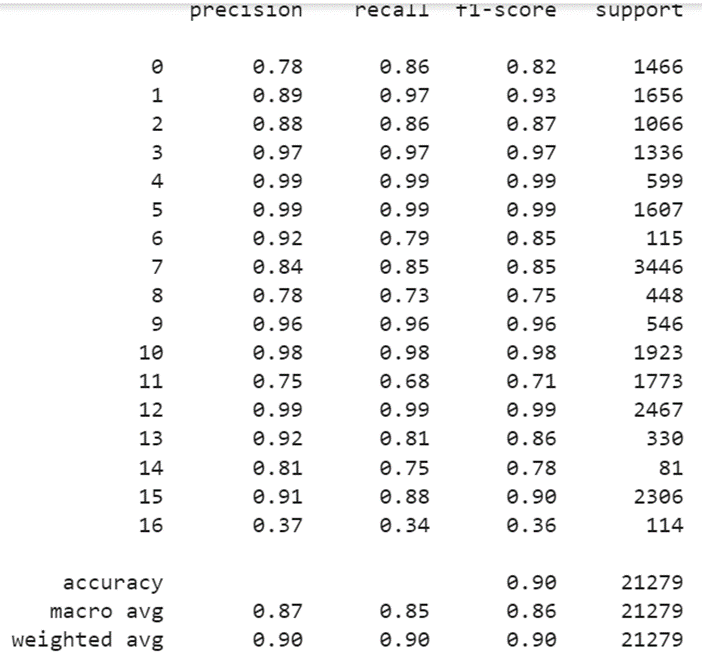